# Progowanie i segmentacja

In [1]:
import cv2
from matplotlib import pyplot as plt

def plot_cv2(image):
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    )

plt.rcParams['figure.figsize'] = [16, 8]

### a) Proszę wczytać przykładowy obraz i skonwertować go do skali szarości

Wymiary obrazu:  (580, 880, 3)


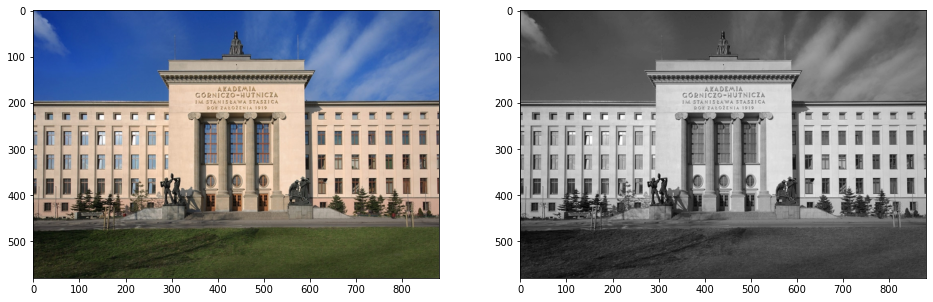

In [2]:
image = cv2.imread("lab3_1.jpg")
print(f"Wymiary obrazu:  {image.shape}")
f = plt.figure()
ax = f.add_subplot(1, 2, 1)
plot_cv2(image)

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax = f.add_subplot(1, 2, 2)
plt.imshow(image_gray, cmap='gray');

---

### b) Proszę sprawdzić i porównać wynik progowania ze statycznym ustalonym globalnie progiem zrealizowanego z użyciem każdego z dostępnych w OpenCV trybu progowania (`cv2.THRESH_BINARY`, `cv2.THRESH_BINARY_INV`, `cv2.THRESH_TRUNC,` `cv2.THRESH_TOZERO` i `cv2.THRESH_TOZERO_INV`)

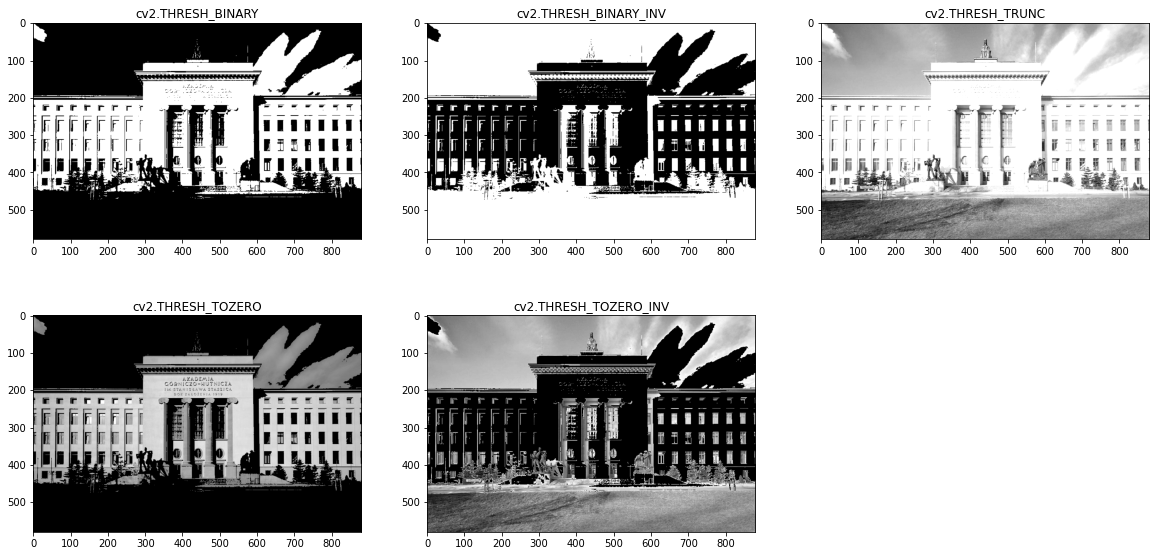

In [3]:
modes = [
    cv2.THRESH_BINARY, 
    cv2.THRESH_BINARY_INV, 
    cv2.THRESH_TRUNC, 
    cv2.THRESH_TOZERO, 
    cv2.THRESH_TOZERO_INV,
]

titles = [
    'cv2.THRESH_BINARY', 
    'cv2.THRESH_BINARY_INV', 
    'cv2.THRESH_TRUNC', 
    'cv2.THRESH_TOZERO', 
    'cv2.THRESH_TOZERO_INV',
]

threshold_ = 120
max_value = 255

f = plt.figure(1, figsize=(20, 26))
for i in range(len(modes)):
    ret, img = cv2.threshold(
        image_gray.copy(),
        threshold_,
        max_value,
        modes[i]
    )
    ax = f.add_subplot(len(modes), 3, i+1)
    ax.set_title(f"{titles[i]}")
    plt.imshow(img, cmap='gray');

---

### c) Proszę zastosować metody adaptacyjnego doboru progu. Jaki wpływ na wynik ma rozmiar sąsiedztwa? Która z metod daje lepsze rezultaty?

#### metoda `cv2.ADAPTIVE_THRESH_MEAN_C`

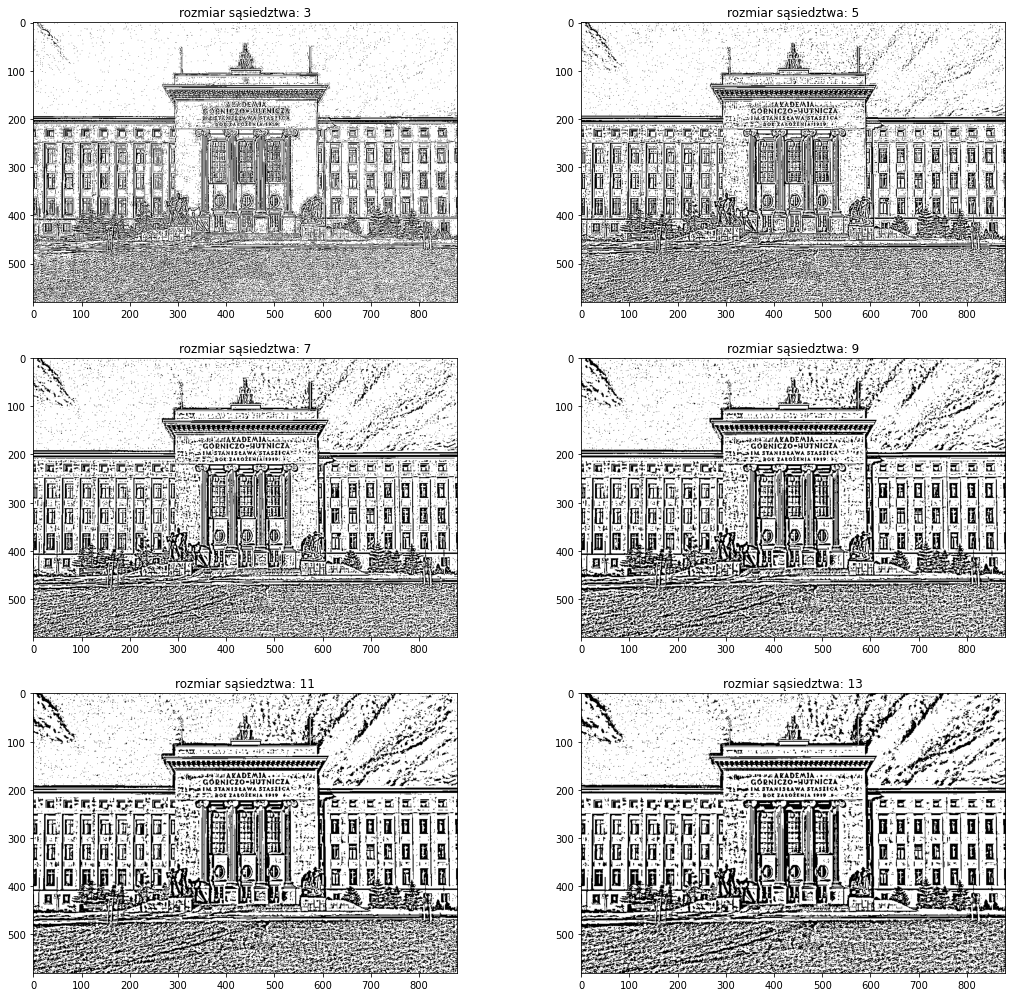

In [4]:
sizes = list(range(3, 14, 2))

f = plt.figure(1, figsize=(18, 18*2))
for i in range(len(sizes)):
    th = cv2.adaptiveThreshold(
        image_gray.copy(), 
        maxValue = 255, 
        adaptiveMethod = cv2.ADAPTIVE_THRESH_MEAN_C, 
        thresholdType = cv2.THRESH_BINARY, 
        blockSize = sizes[i], 
        C = 2
    )
    ax = f.add_subplot(len(sizes), 2, i+1)
    ax.set_title(f"rozmiar sąsiedztwa: {sizes[i]}")
    plt.imshow(th, cmap='gray');
#     f.set_figwidth(30)
#     f.set_figheight(30)
# plt.subplots_adjust(wspace=0, hspace=0.1)
# plt.tight_layout()

#### metoda `cv2.ADAPTIVE_THRESH_GAUSSIAN_C`

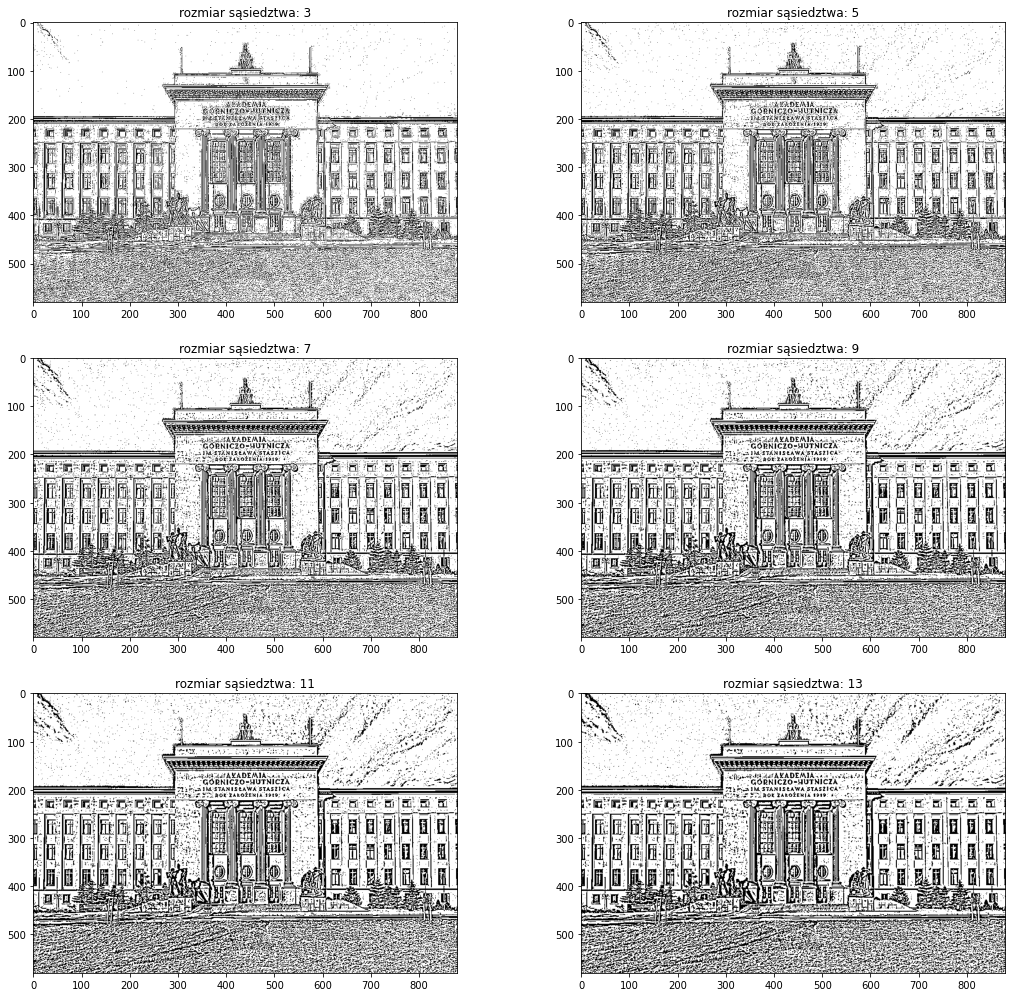

In [5]:
sizes = list(range(3, 14, 2))

f = plt.figure(1, figsize=(18, 18*2))
for i in range(len(sizes)):
    th = cv2.adaptiveThreshold(
        image_gray.copy(), 
        maxValue = 255, 
        adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        thresholdType = cv2.THRESH_BINARY, 
        blockSize = sizes[i], 
        C = 2
    )
    ax = f.add_subplot(len(sizes), 2, i+1)
    ax.set_title(f"rozmiar sąsiedztwa: {sizes[i]}")
    plt.imshow(th, cmap='gray');
#     f.set_figwidth(30)
#     f.set_figheight(30)

---

### d) Proszę zastosować metodę Otsu, wykreślić histogram obrazu i zlokalizować na nim uzyskaną wartość progu

Otrzymany prog: 133.0


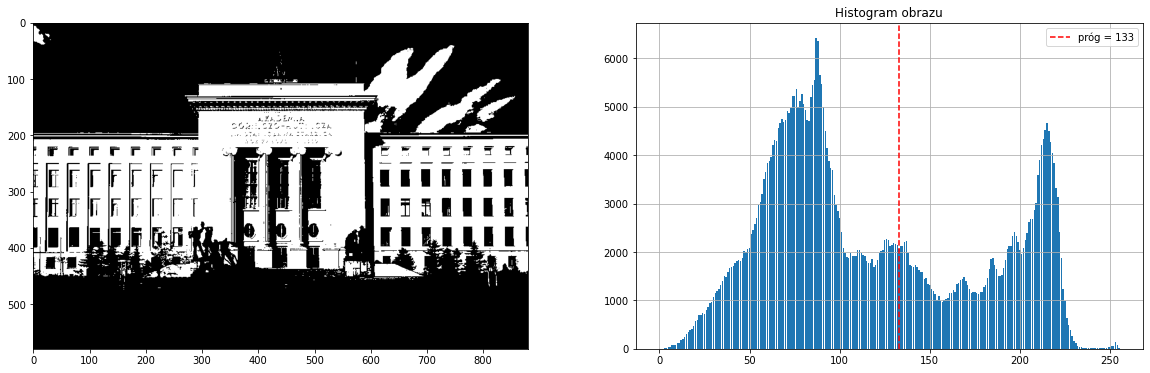

In [6]:
# blur = cv2.GaussianBlur(image_gray.copy(),(5,5),0)
calc_threshold, th_image = cv2.threshold(
    image_gray.copy(), 
    thresh = 120, 
    maxval = 255, 
    type = cv2.THRESH_BINARY + cv2.THRESH_OTSU
) 

print(f"Otrzymany prog: {calc_threshold}")

f = plt.figure(1, figsize=(20, 6))
ax = f.add_subplot(1, 2, 1)
plt.imshow(th_image, cmap='gray');

hist = cv2.calcHist(
    [image_gray], 
    channels = [0], 
    mask = None, 
    histSize = [256,], #liczba binow dla kazdego kanalu
    ranges = [0, 256]
)

ax = f.add_subplot(1, 2, 2)
plt.title("Histogram obrazu")
plt.bar(list(range(0, 256)), height=hist.flatten().tolist())
plt.axvline(calc_threshold, color='red', linestyle='--', label=f"próg = {calc_threshold:.0f}")
plt.grid()
plt.legend()

---

### f) Proszę samodzielnie zaimplementować metodę Otsu. Czy otrzymany próg różni się od bibliotecznej implementacji? Jeśli tak to dlaczego?

In [7]:
import numpy as np

def my_otsu(image, v_min = 0, v_max = 255):
    histogram = cv2.calcHist(
        [image], 
        channels = [0], 
        mask = None, 
        histSize = [v_max - v_min + 1,], #liczba binow dla kazdego kanalu
        ranges = [v_min, v_max+1]
    )
    
    #normowanie histogramu do [0, 1]
    normed_histogram = histogram.ravel()/histogram.sum()
    cdf = np.cumsum( normed_histogram.ravel() )
    
    threshold = None
    bins = np.arange(v_min, v_max+1, 1)
    
    #na poczatku ustawiamy minimalna wariancje na nieskonczonosc
    variance_min = np.inf
    
    for t in range(v_min, v_max):
        w1, w2 = cdf[t], cdf[v_max] - cdf[t]
        
        #zabezpieczenie przed zerowym prawdopodobienstwem i dzieleniem przez 0 w dalszych krokach
        if w1 < 1e-6 or w2 < 1e-6:
            continue
        
        #podzial pikseli na te, ktorych wartosci <= t oraz > t
        p1, p2 = np.hsplit(normed_histogram, [t]) 
        
        #biny potrzebne aby przemnozyc je z ich prawdopodobienstwem
        b1, b2 = np.hsplit(bins, [t]) 
        
        mu1, mu2 = np.sum(p1*b1)/w1, np.sum(p2*b2)/w2
        
        var1 = np.sum( p1 * (b1-mu1)**2  ) / w1
        var2 = np.sum( p2 * (b2-mu2)**2  ) / w2
        
        variance = var1*w1 + var2*w2
        
        #jesli nowa wariancja jest mniejsza od poprzedniej, to jako wynik zapisujemy aktualne t
        if variance < variance_min:
            variance_min = variance
            threshold = t
        
    return threshold

print(f"Próg otrzymany przez OpenCV: {calc_threshold}")
print(f"Próg otrzymany przeze mnie : {my_otsu(image_gray)}")

Próg otrzymany przez OpenCV: 133.0
Próg otrzymany przeze mnie : 134


---

### e) Proszę wczytać drugi z obrazów i dokonać jego segmentacji z użyciem algorytmu k-średnich na 2, 4, 8 klastrów. Proszę zweryfikować wizualnie wynik klasteryzacji (kolor każdego piksela to kolor środka klastra do którego go przypisaliśmy) i sprawdzić czy kolory odpowiadają jakimś cechom zdjęcia które analizujemy.

Wymiary obrazu:  (330, 490, 3)



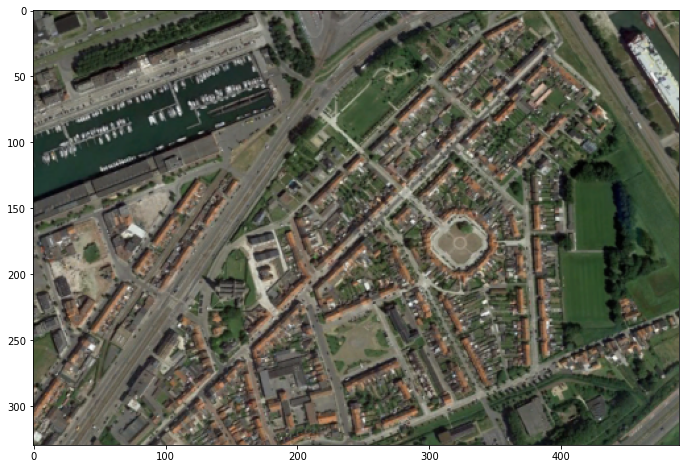

In [8]:
image = cv2.imread("lab3_2.png")
print(f"Wymiary obrazu:  {image.shape}\n")
f = plt.figure(1)
plot_cv2(image)

(161700, 3)


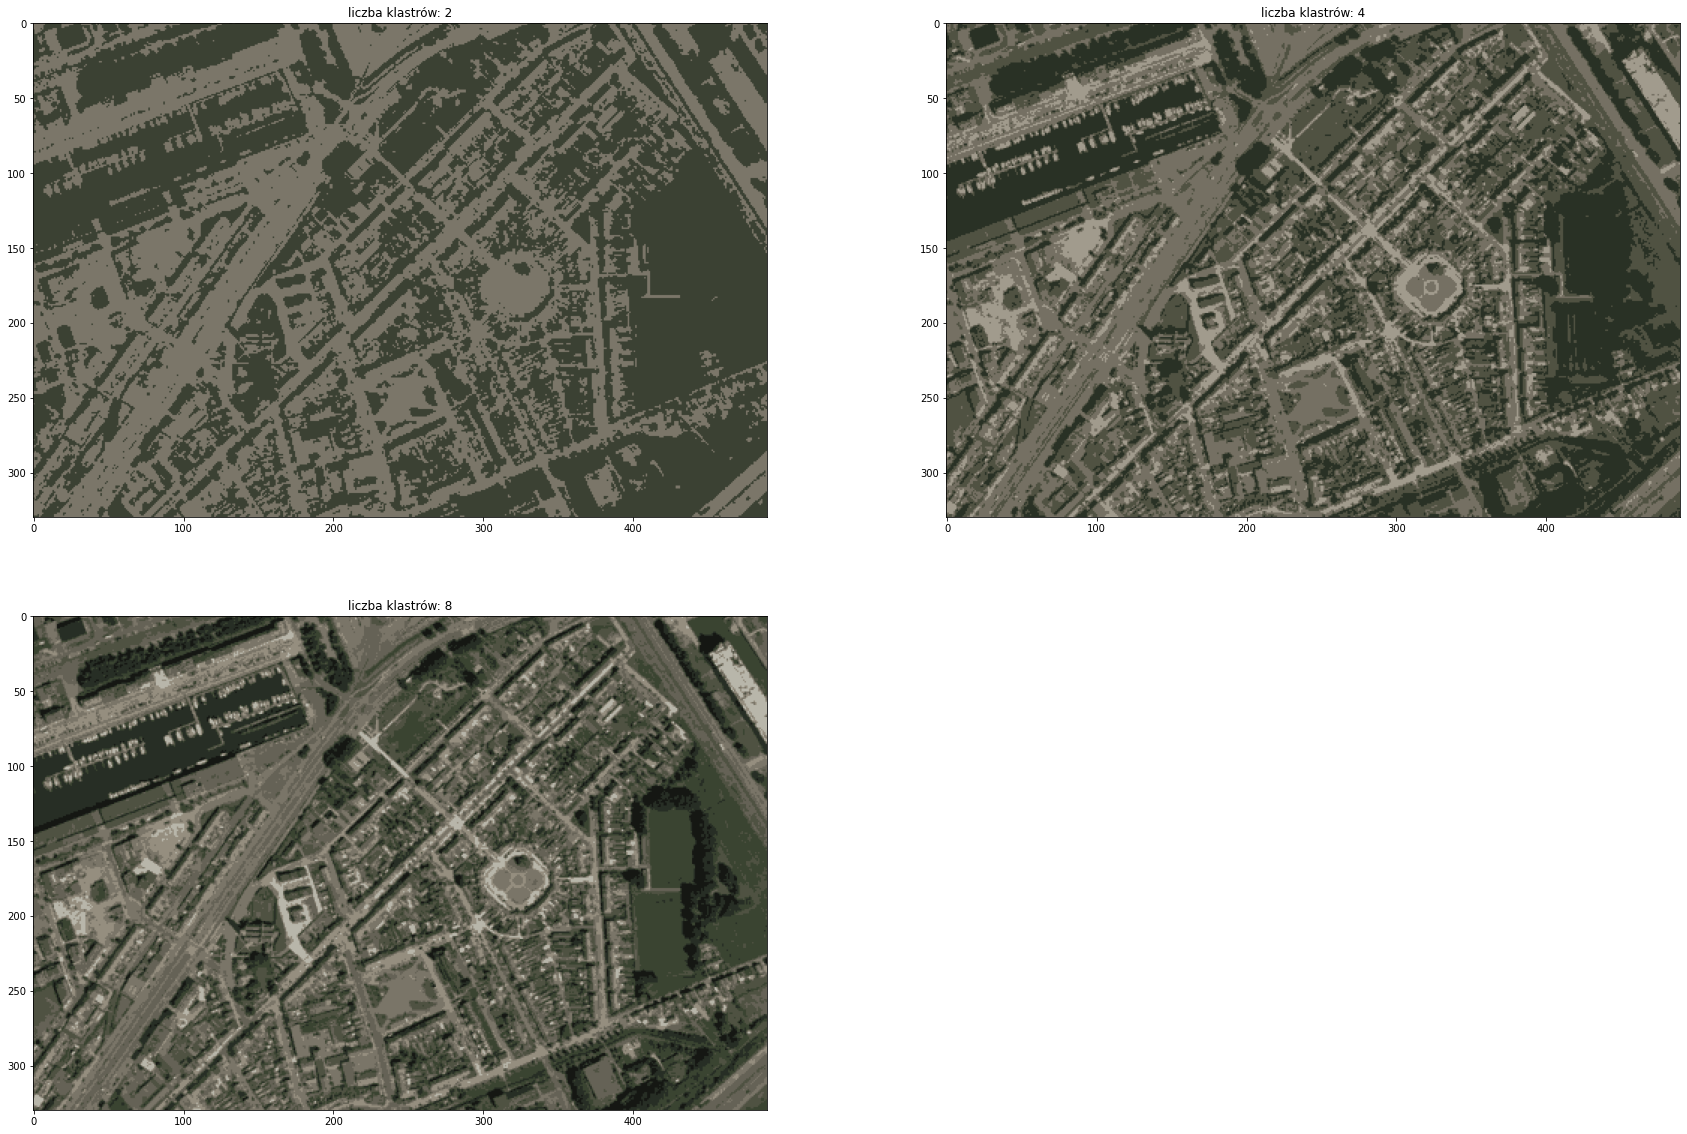

In [9]:
# każda kolumna musi stanowic osobna ceche
# dlatego obraz jest splaszczany do 2D: numer i kanal
pixel_values = image.reshape((-1, 3))

pixel_values = np.float32(pixel_values)
print(pixel_values.shape)

num_of_clstrs = [2, 4, 8]
f = plt.figure(1, figsize=(30, 20))

for i, K in enumerate(num_of_clstrs):
    _, labels, (centers) = cv2.kmeans(
        pixel_values, 
        K = K, 
        bestLabels = None, 
        criteria = (
            cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, #type
            100, #max_iter
            0.8 #epsilon - required accuracy
        ), 
        attempts = 12, 
        flags = cv2.KMEANS_RANDOM_CENTERS
    )

    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()

    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]

    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    # show the image
    f.add_subplot(2, 2, i+1)
    plot_cv2(segmented_image)
    plt.title(f"liczba klastrów: {K}")